In [24]:
import torch
import GPUtil
GPUtil.getAvailable()

use_cuda = torch.cuda.is_available()

if use_cuda:
    print('__CUDNN VERSION:', torch.backends.cudnn.version())
    print('__Number CUDA Devices:', torch.cuda.device_count())
    print('__CUDA Device Name:',torch.cuda.get_device_name(0))
    print('__CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX 6000 Ada Generation
__CUDA Device Total Memory [GB]: 50.904301568


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision import models
from PIL import Image

transform = transforms.Compose([
    #transforms.Resize(224),  # ResNet50 expects 224x224 input size
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

#CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# pretrained resnet50 that we are going to fine tune on c10
# model = models.resnet50(weights=True)

# pretrained resnet18 that we are going to fine tune on c10
model = models.resnet18(weights=True)

# modify the final fully connected layer for CIFAR-10
num_classes = 10
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

optimizer = optim.SGD(model.parameters(), lr=0.08, momentum=0.8, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


for param in model.fc.parameters():
    param.requires_grad = True

Files already downloaded and verified
Files already downloaded and verified
cuda


/hpc/group/wengerlab/hdv2/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# Training function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if (i+1) % 100 == 0:  
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.2f}%')

        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')


train_model(model, train_loader, criterion, optimizer, device, num_epochs=30)

Epoch [1/30], Step [100/500], Loss: 2.9965, Accuracy: 13.29%
Epoch [1/30], Step [200/500], Loss: 4.5143, Accuracy: 13.97%
Epoch [1/30], Step [300/500], Loss: 3.0330, Accuracy: 14.87%
Epoch [1/30], Step [400/500], Loss: 3.1456, Accuracy: 15.93%
Epoch [1/30], Step [500/500], Loss: 2.4197, Accuracy: 17.50%
Epoch 1, Loss: 3.1082, Accuracy: 17.50%
Epoch [2/30], Step [100/500], Loss: 1.7401, Accuracy: 29.60%
Epoch [2/30], Step [200/500], Loss: 1.5858, Accuracy: 32.22%
Epoch [2/30], Step [300/500], Loss: 1.7491, Accuracy: 34.40%
Epoch [2/30], Step [400/500], Loss: 1.6427, Accuracy: 36.48%
Epoch [2/30], Step [500/500], Loss: 1.5016, Accuracy: 38.33%
Epoch 2, Loss: 1.7572, Accuracy: 38.33%
Epoch [3/30], Step [100/500], Loss: 1.5378, Accuracy: 47.53%
Epoch [3/30], Step [200/500], Loss: 1.5053, Accuracy: 48.73%
Epoch [3/30], Step [300/500], Loss: 1.3330, Accuracy: 49.14%
Epoch [3/30], Step [400/500], Loss: 1.5279, Accuracy: 50.05%
Epoch [3/30], Step [500/500], Loss: 1.2916, Accuracy: 51.19%
Epoch

# Performance on test set

In [27]:
# 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
class_0_correct = 0
class_1_correct = 0
class_2_correct = 0
class_3_correct = 0
class_4_correct = 0
class_5_correct = 0
class_6_correct = 0
class_7_correct = 0
class_8_correct = 0
class_9_correct = 0

# TESTING SINGLE IMAGE
# image, label = test_dataset[1]
# image = image.unsqueeze(0).to(device)  

# model.eval()
# with torch.no_grad():
#     output = model(image)
#     print(output)
#     print(torch.softmax(output, dim=1))

#     # get the predicted class
#     print(torch.max(output, 1))
#     _, predicted_class = torch.max(output, 1)

# # back to (H, W, C) for visualization
# image = image.squeeze(0).cpu().permute(1, 2, 0).numpy()


# plt.imshow(image)
# plt.title(f'Predicted Class: {predicted_class.item()}')
# plt.show()

for i in range(len(test_dataset)):
    image, label = test_dataset[i]
    if label == 0:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            # print(predicted_class)
            # print(predicted_class == label)
            if predicted_class == label:
                class_0_correct += 1
    elif label == 1:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_1_correct += 1
    elif label == 2:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_2_correct += 1
    elif label == 3:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_3_correct += 1
    elif label == 4:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_4_correct += 1
    elif label == 5:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_5_correct += 1
    elif label == 6:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_6_correct += 1
    elif label == 7:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_7_correct += 1
    elif label == 8:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_8_correct += 1
    elif label == 9:
        # input requirement (C, H, W)
        image = image.unsqueeze(0).to(device)  

        model.eval()
        with torch.no_grad():
            output = model(image)

            # get the predicted class
            _, predicted_class = torch.max(output, 1)
            if predicted_class == label:
                class_9_correct += 1

print(f'Class 0 test accuracy: {class_0_correct/1000}')
print(f'Class 1 test accuracy: {class_1_correct/1000}')
print(f'Class 2 test accuracy: {class_2_correct/1000}')
print(f'Class 3 test accuracy: {class_3_correct/1000}')
print(f'Class 4 test accuracy: {class_4_correct/1000}')
print(f'Class 5 test accuracy: {class_5_correct/1000}')
print(f'Class 6 test accuracy: {class_6_correct/1000}')
print(f'Class 7 test accuracy: {class_7_correct/1000}')
print(f'Class 8 test accuracy: {class_8_correct/1000}')
print(f'Class 9 test accuracy: {class_9_correct/1000}')

total_correct = class_0_correct + class_1_correct + class_2_correct + class_3_correct + class_4_correct + class_5_correct + class_6_correct + class_7_correct + class_8_correct + class_9_correct
print(f'Over all acurracy: {total_correct/10000}')


Class 0 test accuracy: 0.629
Class 1 test accuracy: 0.719
Class 2 test accuracy: 0.619
Class 3 test accuracy: 0.432
Class 4 test accuracy: 0.856
Class 5 test accuracy: 0.487
Class 6 test accuracy: 0.88
Class 7 test accuracy: 0.602
Class 8 test accuracy: 0.569
Class 9 test accuracy: 0.675
Over all acurracy: 0.6468


In [28]:
import sys
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import time

# From Eli's github

In [29]:
pip install segment_anything

Note: you may need to restart the kernel to use updated packages.


In [30]:
from segment_anything import sam_model_registry, SamPredictor

In [31]:
def show_anns(anns,display="all",mask_num=0):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    if display == "all":
        for ann in sorted_anns:
            m = ann['segmentation']
            color_mask = np.concatenate([np.random.random(3), [0.35]])
            img[m] = color_mask
    elif display == "single_mask":
        ann = sorted_anns[mask_num]
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25) 

In [32]:
import os

print(os.getcwd())

/hpc/group/wengerlab/hdv2/CS590: AI/ML security


In [33]:
# sam_h = sam_model_registry["vit_h"](checkpoint="/hpc/group/wengerlab/hdv2/CS590: AI/sam_vit_h_4b8939.pth")
# mask_h_predictor = SamPredictor(sam_h)
sam_h = sam_model_registry["vit_h"](checkpoint="/hpc/group/wengerlab/hdv2/CS590: AI/sam_vit_h_4b8939.pth")
sam_h = sam_h.to(device)  # move to GPU
mask_h_predictor = SamPredictor(sam_h)

sam_b = sam_model_registry["vit_b"](checkpoint="/hpc/group/wengerlab/hdv2/CS590: AI/sam_vit_b_01ec64.pth")
sam_b = sam_b.to(device)  # move to GPU
mask_b_predictor = SamPredictor(sam_b)

/hpc/group/wengerlab/hdv2/miniconda3/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)

# Testing single image sam_h

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
<class 'numpy.ndarray'>
(32, 32, 3)
True Label: 6, Predicted Class: 6


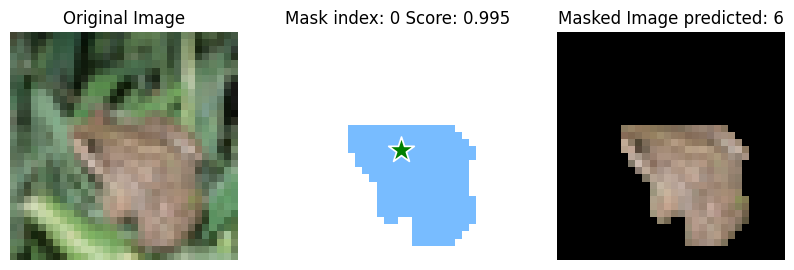

In [34]:
input_point = np.array([[16, 16]])  
input_label = np.array([1])        

for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label = test_dataset[4]

    print(type(image))
    print(image.shape)

    image_np = np.array(image.permute(1,2,0))

    print(type(image_np))
    print(image_np.shape)

    #change sam predictor here
    mask_h_predictor.set_image(image_np)
    h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(h_t1_scores)
    best_mask = h_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)
    
    print(f"True Label: {label}, Predicted Class: {predicted_class.item()}")


    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # best mask
    plt.subplot(1, 3, 2)
    show_mask(best_mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f'Mask index: {best_mask_index} Score: {h_t1_scores[best_mask_index]:.3f}')
    plt.axis('off')

    # masked image
    plt.subplot(1, 3, 3)
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    plt.imshow(masked_image_np)
    plt.title(f"Masked Image predicted: {predicted_class.item()}")
    plt.axis('off')

    plt.show()

    

    break  


# whole test set using vit_h

In [35]:
from tqdm import tqdm

input_point = np.array([[16, 16]])  
input_label = np.array([1])        

total_correct = 0
class_0_correct = 0
class_1_correct = 0
class_2_correct = 0
class_3_correct = 0
class_4_correct = 0
class_5_correct = 0
class_6_correct = 0
class_7_correct = 0
class_8_correct = 0
class_9_correct = 0

for i in tqdm(range(len(test_dataset))):
    # Load image and label from test dataset
    image, label = test_dataset[i]

    image_np = np.array(image.permute(1,2,0))

    #change sam predictor here
    mask_h_predictor.set_image(image_np)
    h_t1_masks, h_t1_scores, h_t1_logits = mask_h_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(h_t1_scores)
    best_mask = h_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)

    if (label == 0) and (predicted_class == label):
        total_correct += 1
        class_0_correct += 1
    elif (label == 1) and (predicted_class == label):
        total_correct += 1
        class_1_correct += 1
    elif (label == 2) and (predicted_class == label):
        total_correct += 1
        class_2_correct += 1
    elif (label == 3) and (predicted_class == label):
        total_correct += 1
        class_3_correct += 1
    elif (label == 4) and (predicted_class == label):
        total_correct += 1
        class_4_correct += 1
    elif (label == 5) and (predicted_class == label):
        total_correct += 1
        class_5_correct += 1
    elif (label == 6) and (predicted_class == label):
        total_correct += 1
        class_6_correct += 1
    elif (label == 7) and (predicted_class == label):
        total_correct += 1
        class_7_correct += 1
    elif (label == 8) and (predicted_class == label):
        total_correct += 1
        class_8_correct += 1
    elif (label == 9) and (predicted_class == label):
        total_correct += 1
        class_9_correct += 1

print(f'Test set accuracy: {total_correct/10000}')
print(f'Class 0 test accuracy: {class_0_correct/1000}')
print(f'Class 1 test accuracy: {class_1_correct/1000}')
print(f'Class 2 test accuracy: {class_2_correct/1000}')
print(f'Class 3 test accuracy: {class_3_correct/1000}')
print(f'Class 4 test accuracy: {class_4_correct/1000}')
print(f'Class 5 test accuracy: {class_5_correct/1000}')
print(f'Class 6 test accuracy: {class_6_correct/1000}')
print(f'Class 7 test accuracy: {class_7_correct/1000}')
print(f'Class 8 test accuracy: {class_8_correct/1000}')
print(f'Class 9 test accuracy: {class_9_correct/1000}')

100%|██████████| 10000/10000 [51:19<00:00,  3.25it/s]

Test set accuracy: 0.4032
Class 0 test accuracy: 0.372
Class 1 test accuracy: 0.555
Class 2 test accuracy: 0.502
Class 3 test accuracy: 0.33
Class 4 test accuracy: 0.512
Class 5 test accuracy: 0.241
Class 6 test accuracy: 0.815
Class 7 test accuracy: 0.195
Class 8 test accuracy: 0.215
Class 9 test accuracy: 0.295


# Testing single image sam_b

<class 'torch.Tensor'>
torch.Size([3, 32, 32])
<class 'numpy.ndarray'>
(32, 32, 3)
True Label: 6, Predicted Class: 6


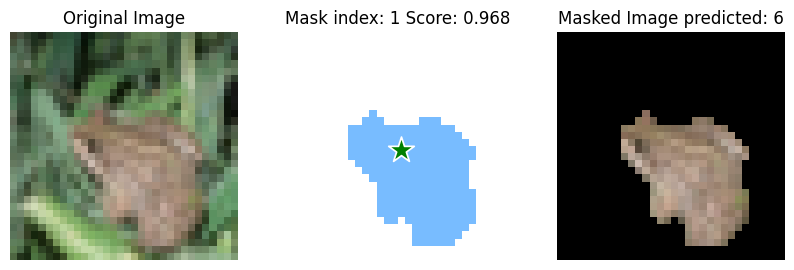

In [36]:
input_point = np.array([[16, 16]])  
input_label = np.array([1])        

for i in range(len(test_dataset)):
    # Load image and label from test dataset
    image, label = test_dataset[4]

    print(type(image))
    print(image.shape)

    image_np = np.array(image.permute(1,2,0))

    print(type(image_np))
    print(image_np.shape)

    #change sam predictor here
    mask_b_predictor.set_image(image_np)
    b_t1_masks, b_t1_scores, b_t1_logits = mask_b_predictor.predict(point_coords=input_point, point_labels=input_label,multimask_output=True)

    best_mask_index = np.argmax(b_t1_scores)
    best_mask = b_t1_masks[best_mask_index]

    #  the mask to the image
    best_mask_tensor = torch.tensor(best_mask, dtype=torch.float32).to(device)
    image_tensor = transforms.ToTensor()(image_np).to(device)  
    masked_image = image_tensor * best_mask_tensor.unsqueeze(0)  

    # make predictions on masked image
    model.eval()
    test_image = masked_image.unsqueeze(0).to(device) 
    with torch.no_grad():
        output = model(test_image)
        _, predicted_class = torch.max(output, 1)
    
    print(f"True Label: {label}, Predicted Class: {predicted_class.item()}")


    plt.figure(figsize=(10, 5))

    # original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    # best mask
    plt.subplot(1, 3, 2)
    show_mask(best_mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f'Mask index: {best_mask_index} Score: {h_t1_scores[best_mask_index]:.3f}')
    plt.axis('off')

    # masked image
    plt.subplot(1, 3, 3)
    masked_image_np = masked_image.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
    plt.imshow(masked_image_np)
    plt.title(f"Masked Image predicted: {predicted_class.item()}")
    plt.axis('off')

    plt.show()

    

    break  
